<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preparation</a></span></li><li><span><a href="#explore-data" data-toc-modified-id="explore-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>explore data</a></span></li><li><span><a href="#processed-data" data-toc-modified-id="processed-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>processed data</a></span></li><li><span><a href="#build-model-1:-decision-tree" data-toc-modified-id="build-model-1:-decision-tree-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>build model 1: decision tree</a></span></li><li><span><a href="#build-random-forest" data-toc-modified-id="build-random-forest-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>build random forest</a></span></li><li><span><a href="#hyper-parameter-tuning" data-toc-modified-id="hyper-parameter-tuning-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>hyper parameter tuning</a></span></li><li><span><a href="#learning-curve" data-toc-modified-id="learning-curve-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>learning curve</a></span><ul class="toc-item"><li><span><a href="#summary:" data-toc-modified-id="summary:-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>summary:</a></span></li></ul></li><li><span><a href="#visualize-decision-surface" data-toc-modified-id="visualize-decision-surface-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>visualize decision surface</a></span></li><li><span><a href="#to-do" data-toc-modified-id="to-do-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>to do</a></span></li></ul></div>

# wine quality prediction based on chemical properties

- predict the quality of a wine based on the chemical properties of the wine.
- dataset: wine quality dataset hosted on the <a href="https://archive.ics.uci.edu/ml/datasets/Wine+Quality">UCI website</a>. 
- barplot analyze quality dependence on chemicals.

In [105]:
import numpy as np
import scipy as sp
import pandas as pd
import sklearn
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_score

##  Data preparation

Import data

In [106]:
df = pd.read_csv('winequality-red.csv',sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


total 1599. no NaN object.

- features: all columns except quality.
- target: quality
- classified quality into bad $(score<7)$ or good $(score>7)$ into 0 or 1.

## explore data

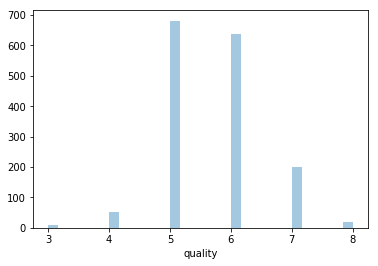

In [108]:
# how does the quality distributed?
sns.distplot(df.quality,kde=False)

almost gaussian-like. with most quality at 5.

In [109]:
list_features = df.columns.tolist()
list_features[:-1]

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

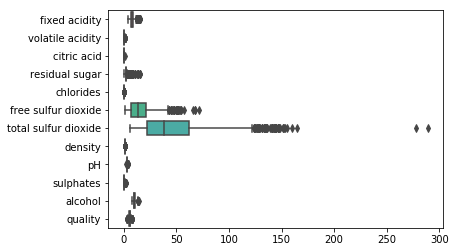

In [110]:
# univariate 
sns.boxplot(data=df,orient='h')

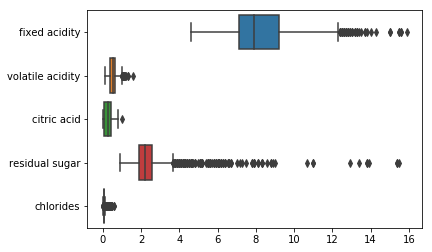

In [111]:
sns.boxplot(data=df.iloc[:,0:5],orient='h')

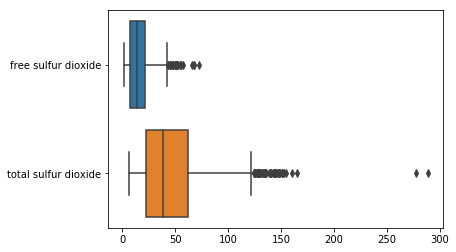

In [112]:
sns.boxplot(data=df.iloc[:,5:7],orient='h')

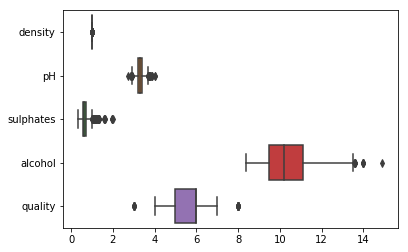

In [113]:
sns.boxplot(data=df.iloc[:,7:],orient='h')

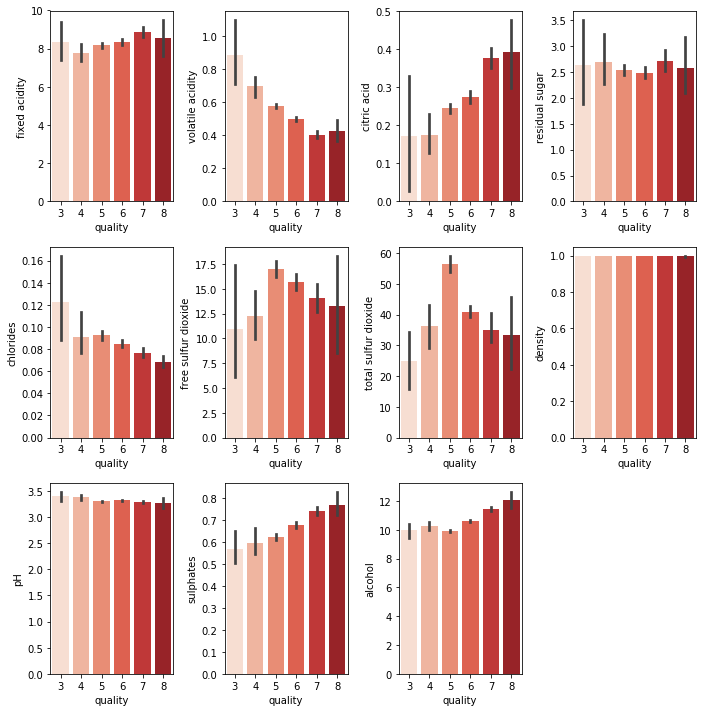

In [114]:
# how the quality related to features?
j=0
plt.figure(figsize=(10,10))
for i in list_features[:-1]:
    j+=1
    plt.subplot(3, 4,j )

    sns.barplot(x='quality',y=i,palette='Reds',data=df)

plt.tight_layout()
plt.savefig('./figures/features.png')

we can see that there are correlations of quality with these features: 'volatile acidity',
 'citric acid',
 'chlorides',
 'pH',
 'sulphates',
 'alcohol'

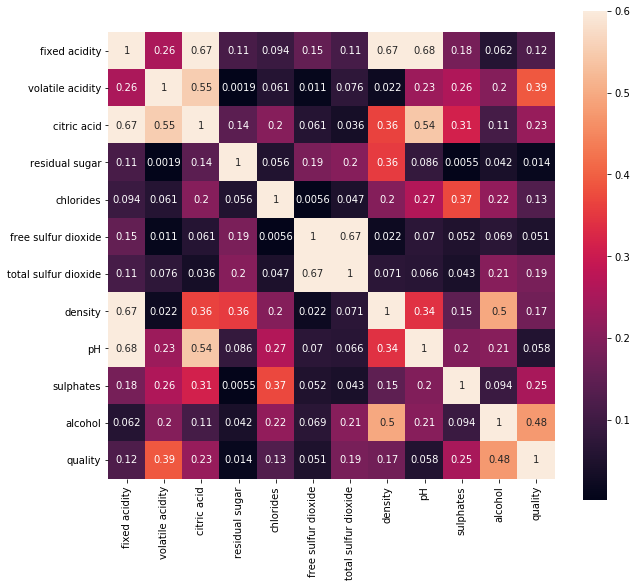

In [115]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(10, 9))
sns.heatmap(abs(corrmat), vmax=0.6, square=True,annot=True)
plt.savefig('./figures/corrmat.png')

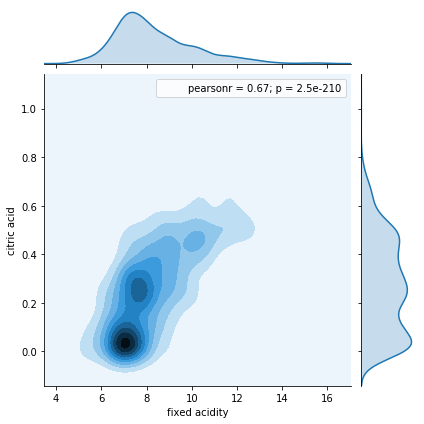

In [116]:
sns.jointplot(x='fixed acidity', y="citric acid", data=df, kind="kde");

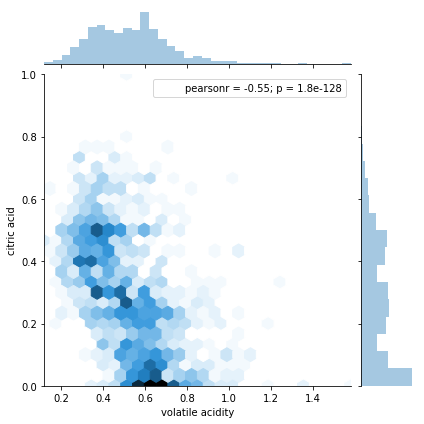

In [117]:
sns.jointplot(x='volatile acidity', y="citric acid", data=df, kind="hex");

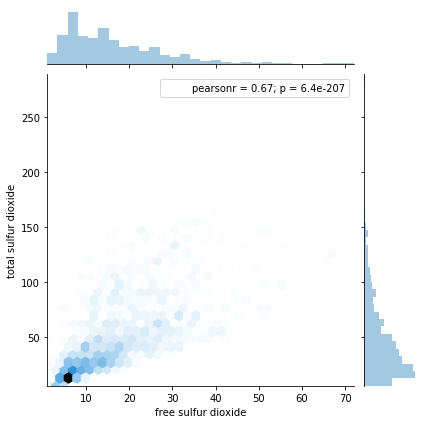

In [118]:
sns.jointplot(x='free sulfur dioxide', y="total sulfur dioxide", data=df, kind="hex");

## processed data
- I binarized the quality into two group, quality $\le$6 as bad and quality $\ge$ 7 as good.
- set aside test set.
- there are less good wine than bad wine. so resample the data to make it balanced.
- apply standard scaler
- split into train and dev set

In [130]:
# binarized
df.quality = df.quality.apply(lambda x:1 if x>=7 else 0)


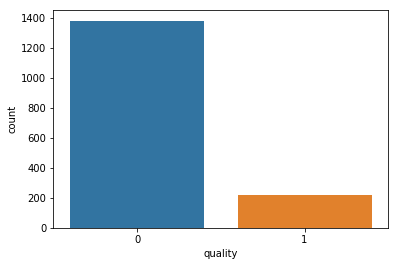

In [134]:
sns.countplot(df.quality)

In [131]:
# apply standard scaler
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
df.iloc[:,:-1] = sc.fit_transform(df.iloc[:,:-1])


In [133]:
# check
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,0
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777,0
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777,0
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777,0
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,0


In [135]:
# set aside test set
df_test = df.sample(frac = 0.2,random_state=1)
df_train_dev = df.drop(df_test.index)
df_test.shape,df_train_dev.shape


((320, 12), (1279, 12))

In [136]:
# make the train_dev data set balance.
from sklearn.utils import resample


df_majority = df_train_dev[df_train_dev.quality==0]
df_minority = df_train_dev[df_train_dev.quality==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=df_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results

In [137]:
# check the number
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_upsampled.quality.value_counts()

1    1094
0    1094
Name: quality, dtype: int64

In [142]:
from sklearn.model_selection import train_test_split

X_train,X_dev,y_train,y_dev=train_test_split(df_upsampled.iloc[:,:-1],df_upsampled.iloc[:,-1],test_size=0.2, random_state = 42)

In [145]:
X_train.shape,X_dev.shape

((1750, 11), (438, 11))

## build model 1: decision tree

In [20]:
# identifying the most important factors.
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import classification_report

tree_clf=DecisionTreeClassifier()
cross_val_score(tree_clf,X_train,y_train)

/Users/yongsingyou/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


array([0.84777518, 0.85714286, 0.87294118])

In [21]:
tree_clf.fit(X_train,y_train)
pred_tree_clf = tree_clf.predict(X_test)
print(classification_report(y_test, pred_tree_clf))

             precision    recall  f1-score   support

          0       0.93      0.93      0.93       273
          1       0.60      0.57      0.59        47

avg / total       0.88      0.88      0.88       320



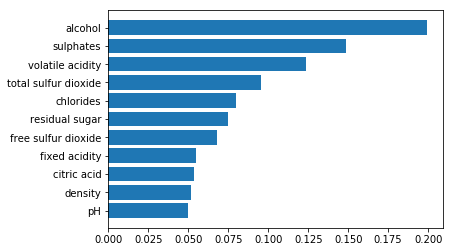

In [22]:
list_importance = tree_clf.feature_importances_
list_name = dfx.columns
list_importance, list_name = zip(*sorted(zip(list_importance, list_name)))
plt.barh(range(len(list_importance)),list_importance)
plt.yticks(range(len(list_name)),list_name)
plt.show()

## build random forest


In [208]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import classification_report

In [209]:
random_clf = RandomForestClassifier(n_estimators=200)
random_clf.fit(X_train, y_train)
pred_random_clf = random_clf.predict(X_dev)
print(classification_report(y_dev, pred_random_clf))

             precision    recall  f1-score   support

          0       1.00      0.95      0.97       217
          1       0.95      1.00      0.98       221

avg / total       0.98      0.97      0.97       438



In [210]:
from sklearn.metrics import f1_score,accuracy_score


f1_score(y_dev, pred_random_clf),accuracy_score(y_dev, pred_random_clf)

(0.9757174392935983, 0.9748858447488584)

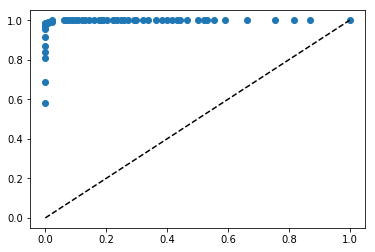

In [157]:
prob_random_clf = random_clf.predict_proba(X_dev)

fpr_grd, tpr_grd, _ = roc_curve(y_dev, prob_random_clf[:,1])
plt.plot(fpr_grd,tpr_grd,'o')
plt.plot([0, 1], [0, 1], 'k--')

#auc_score = roc_auc_score(y_dev, pred_random_clf[:,1])
#print('auc score is %f'% auc_score)

In [156]:
prob_random_clf[:,1].shape, y_dev.shape

((438,), (438,))

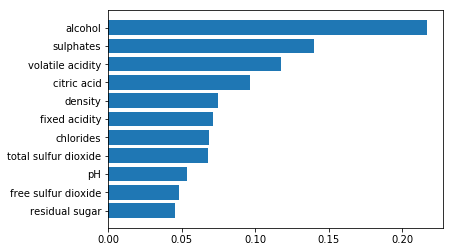

In [153]:
# identifying the most important factors.
list_importance = random_clf.feature_importances_
list_name = X_train.columns
list_importance, list_name = zip(*sorted(zip(list_importance, list_name)))
plt.barh(range(len(list_importance)),list_importance)
plt.yticks(range(len(list_name)),list_name)
plt.show()

## hyper parameter tuning

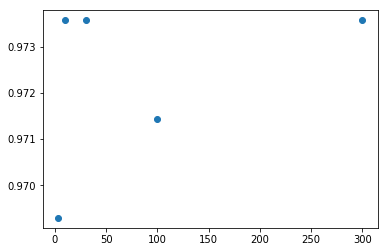

In [181]:
arr = [3,10,30,100,300]
f1s = []
for i in arr:
    random_clf = RandomForestClassifier(n_estimators=i,random_state=1)
    random_clf.fit(X_train, y_train)
    pred_random_clf = random_clf.predict(X_dev)
    f1s.append(f1_score(y_dev,pred_random_clf))
plt.plot(arr,f1s,'o')

In [182]:
random_clf.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

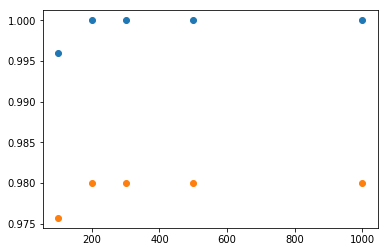

In [191]:
arr = [100,200,300,500,1000]
train_f1 = []
dev_f1 = []
for i in arr:
    random_clf = RandomForestClassifier(random_state = 1,n_estimators=30 , max_leaf_nodes=i)
    random_clf.fit(X_train, y_train)
    train_f1.append(f1_score(y_train,random_clf.predict(X_train)))

    pred_random_clf = random_clf.predict(X_dev)
    dev_f1.append(f1_score(y_dev,pred_random_clf))

plt.plot(arr,train_f1,'o')  
plt.plot(arr,dev_f1,'o')

In [186]:
random_clf.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': 3000,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 30,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

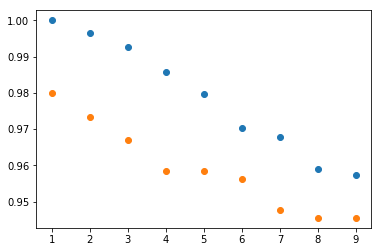

In [257]:
arr = range(1,10,1)
train_f1 = []
dev_f1 = []
for i in arr:
    random_clf = RandomForestClassifier(random_state = 1,n_estimators=30 , max_leaf_nodes=200,min_samples_leaf=i)
    random_clf.fit(X_train, y_train)
    train_f1.append(f1_score(y_train,random_clf.predict(X_train)))

    pred_random_clf = random_clf.predict(X_dev)
    dev_f1.append(f1_score(y_dev,pred_random_clf))

plt.plot(arr,train_f1,'o')  
plt.plot(arr,dev_f1,'o')



Text(0.5,1,'max_depth')

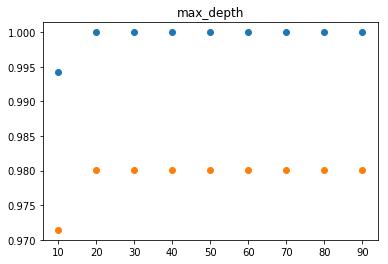

In [263]:
arr = range(10,100,10)
train_f1 = []
dev_f1 = []
for i in arr:
    random_clf = RandomForestClassifier(random_state = 1,n_estimators=30 , max_leaf_nodes=200,max_depth=i)
    random_clf.fit(X_train, y_train)
    train_f1.append(f1_score(y_train,random_clf.predict(X_train)))

    pred_random_clf = random_clf.predict(X_dev)
    dev_f1.append(f1_score(y_dev,pred_random_clf))

plt.plot(arr,train_f1,'o')  
plt.plot(arr,dev_f1,'o')
plt.title('max_depth')

## learning curve

In [217]:
train_error = []
dev_error = []
for m in range(10,len(X_train),10):
    random_clf = RandomForestClassifier(random_state = 1,n_estimators=30 , max_leaf_nodes=200)
    random_clf.fit(X_train[:m], y_train[:m])
    train_error.append(accuracy_score( y_train[:m],random_clf.predict(X_train[:m])))

    pred_random_clf = random_clf.predict(X_dev)
    dev_error.append(accuracy_score(y_dev,pred_random_clf))

Text(0.5,1,'learning curves')

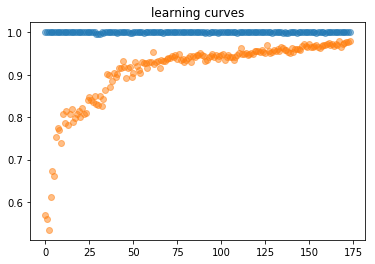

In [242]:
plt.plot(train_error,'o',alpha=0.5)
plt.plot(dev_error,'o',alpha=0.5)
plt.title('learning curves')

In [252]:
def plot_learning_curve(estimator, X, y,cv = 5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title('learning curves')
    #if ylim is not None:
    #    plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/Users/yongsingyou/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

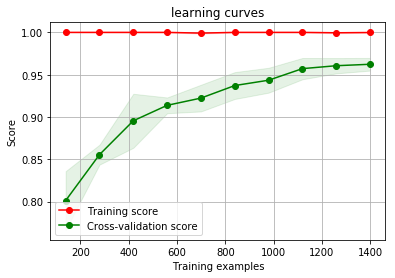

In [253]:
plot_learning_curve(random_clf, X_train,y_train)

In [239]:
# using cross-validation
from sklearn.model_selection import learning_curve
random_clf = RandomForestClassifier(random_state = 1,n_estimators=30 , max_leaf_nodes=200)

train_sizes, train_scores, valid_scores = learning_curve(
    random_clf, X_train, y_train,train_sizes=np.linspace(.1, 1.0, 50), cv=5)

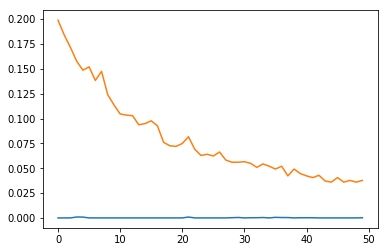

In [240]:
plt.plot(1-np.mean(train_scores,axis=1))
plt.plot(1-np.mean(valid_scores,axis=1))

### summary:
- low bias, higher variance: need to regularized the model. getting more training data

## visualize decision surface

In [102]:
def plot_decision_surface(clf, X_train, Y_train):
    Xmin0 = X_train[:, 0].min()
    Xmin1 = X_train[:, 1].min()
    Xmax0 = X_train[:, 0].max()
    Xmax1 = X_train[:, 1].max() 
    
    plot_step_0=(Xmax0-Xmin0)/50
    plot_step_1=(Xmax1-Xmin1)/50
    
    x_min, x_max = Xmin0, Xmax0
    y_min, y_max = Xmin1, Xmax1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step_0),
                         np.arange(y_min, y_max, plot_step_1))

    clf.fit(X_train,Y_train)
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
   
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.viridis,alpha=0.5)
    plt.scatter(X_train[:,0],X_train[:,1],c=Y,cmap=plt.cm.Paired,alpha=0.5)
    plt.show()

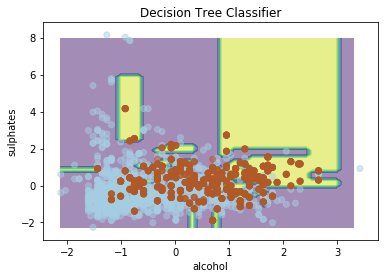

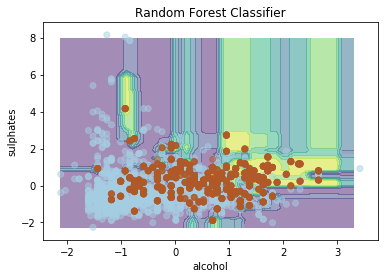

In [103]:
# 
from sklearn.tree import DecisionTreeClassifier
imp_cols = tree_clf.feature_importances_.argsort()[::-1][0:2]
X_imp = X[:,imp_cols]

classifiers = [DecisionTreeClassifier(),
               RandomForestClassifier()]

titleClassifer = ['Decision Tree Classifier', 'Random Forest Classifier']
label_feature = dfx.columns[imp_cols].tolist()


for c in range(2):
    plt.title(titleClassifer[c])
    plt.xlabel(label_feature[0])
    plt.ylabel(label_feature[1])
    plot_decision_surface(classifiers[c], X_imp, Y)

## to do

- feature engineering: for example, ratio between alcohol and sulphate. This will require a good understanding of how chemical ratio affect taste in a wine. 
- bias/variance.
- hyper-parameter tuning
- learning curves